In [1]:
# generic imports 

from bydoux_tools import read_google_sheet_csv
import warnings
import numpy as np
from scipy.optimize import minimize
import bydoux_tools as bt
from astropy.time import Time
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from tqdm import tqdm



In [2]:
# Parameters for the code that may change
force = True
verbose = True

t0 = Time('2024-05-01', format='iso').mjd
t1 = Time.now().mjd

In [3]:
# Fetch the disnat summary table of my accounts

tbl = bt.get_disnat_summary()
tbl = tbl[np.argsort(tbl['mjd'])]

In [4]:
# Construct a time span for the analysis (daily steps)
time_span = np.arange(t0, t1, 1)

tbl0 = Table()
tbl0['mjd'] = time_span

# Read S&P 500 and CAD/USD FX rate data
sp500 = bt.read_quotes('^SPX', force=force)
cadusd = bt.read_quotes('CADUSD=X', force=force)

# Interpolate CAD/USD and SP500 values onto the analysis time grid
tbl0['CADUSD'] = np.interp(tbl0['mjd'], cadusd['mjd'], cadusd['Close'])
tbl0['SP500'] = np.interp(tbl0['mjd'], sp500['mjd'], sp500['Close'])
tbl0['N_SP500'] = 0.0
tbl0['CONTRIBUTIONS'] = 0.0

# Also interpolate SP500 onto the transaction table for reference
tbl['SP500'] = np.interp(tbl['mjd'], sp500['mjd'], sp500['Close'])

# Compute running sum of contributions (COTISATION and TRANSFERT REÇU in CAD)
for i in tqdm(range(len(tbl)),leave = False, desc='Computing contributions'):
    if tbl['Devise du prix'][i] != 'CAN':
        continue
    if tbl['Type de transaction'][i] in ['COTISATION', 'TRANSFERT REÇU']:
        g = tbl0['mjd'] > tbl['mjd'][i]
        tbl0['CONTRIBUTIONS'][g] += tbl["Montant de l'opération"][i]

In [5]:
# Get the symbol of all actions bought or sold: 'Type de transaction' is 'ACHAT' or 'VENTE'
# This block identifies all unique stock symbols that have been bought or sold in the transaction table.

flag = [
    ('ACHAT' in x or 'VENTE' in x)
    for x in tbl['Type de transaction']
]
symbols = np.unique(tbl[flag]['Symbole'])

# For each symbol, trim -C and -U suffixes and try to fetch quotes (prefer .TO for Canadian tickers)
problems = []
for sym in symbols:
    # Remove suffixes like -C, -U, or .TO for lookup
    sym2 = sym.split('-')[0]
    sym2 = sym2.split('.')[0]

    quotes = None
    try:
        # Try to get Canadian ticker first
        quotes = bt.read_quotes(sym2+'.TO', force=force)
    except Exception as e:
        if verbose:
            bt.printc(f"Error reading {sym2}.TO: {e}")

    # If not found, try without .TO
    if quotes is None:
        quotes = bt.read_quotes(sym2, force=force)

    # If still not found, add to problems and skip
    if quotes is None:
        problems.append(sym)
        continue

    # Interpolate the close and dividend-adjusted close values onto the analysis time grid
    val = np.interp(tbl0['mjd'], quotes['mjd'], quotes['Close'])
    val_close_dividend = np.interp(tbl0['mjd'], quotes['mjd'], quotes['Close_dividends'])
    tbl0[sym] = val
    tbl0[sym+'_dividend'] = val_close_dividend

    # Initialize columns for running quantity and value of each symbol
    tbl0[sym+'_quantity'] = 0
    tbl0[sym+'_val'] = 0.0

# For each transaction, update the running quantity and value for each symbol
for i in range(len(tbl)):
    if ('ACHAT' in tbl['Type de transaction'][i]) or ('VENTE' in tbl['Type de transaction'][i]):
        sym = tbl['Symbole'][i]
        g = tbl0['mjd'] > tbl['mjd'][i]
        tbl0[sym+'_quantity'][g] += tbl['Quantité'][i]

        # If the symbol is USD-denominated (contains -U), convert to CAD using CADUSD rate
        if '-U' in sym:
            tbl0[sym+'_val'][g] += tbl['Quantité'][i] * tbl0[sym][g] / tbl0['CADUSD'][g]
        else:
            tbl0[sym+'_val'][g] += tbl['Quantité'][i] * tbl0[sym][g]

21:08:56.105 |  Error reading AXON.TO: cannot guess format from input values with zero-size array or all elements masked
21:08:58.127 |  Error reading CHRW.TO: cannot guess format from input values with zero-size array or all elements masked


$FICO.TO: possibly delisted; no timezone found


21:09:01.496 |  Error reading FICO.TO: cannot guess format from input values with zero-size array or all elements masked


$FTNT.TO: possibly delisted; no timezone found


21:09:01.818 |  Error reading FTNT.TO: cannot guess format from input values with zero-size array or all elements masked


$GEV.TO: possibly delisted; no timezone found


21:09:03.374 |  Error reading GEV.TO: cannot guess format from input values with zero-size array or all elements masked


$IRM.TO: possibly delisted; no timezone found


21:09:04.080 |  Error reading IRM.TO: cannot guess format from input values with zero-size array or all elements masked


$PLTR.TO: possibly delisted; no timezone found


21:09:05.856 |  Error reading PLTR.TO: cannot guess format from input values with zero-size array or all elements masked


$TRGP.TO: possibly delisted; no timezone found


21:09:06.179 |  Error reading TRGP.TO: cannot guess format from input values with zero-size array or all elements masked


$UAL.TO: possibly delisted; no timezone found


21:09:07.938 |  Error reading UAL.TO: cannot guess format from input values with zero-size array or all elements masked


$VST.TO: possibly delisted; no timezone found
$VTR.TO: possibly delisted; no price data found  (period=5d)


21:09:08.357 |  Error reading VST.TO: cannot guess format from input values with zero-size array or all elements masked
21:09:08.547 |  Error reading VTR.TO: cannot guess format from input values with zero-size array or all elements masked


In [6]:
# Compute the total portfolio value at each time step by summing the value of all held symbols
tbl0['val_total'] = 0.0
for sym in symbols:
    tbl0['val_total'] += tbl0[sym+'_val']

# Define the percent gains to scan for the synthetic growth scenarios
percent_gains = [-10, -5, 5, 10, 15, 20]

# Compute the running number of SP500 units purchased with each contribution
for i in range(1, len(tbl0)):
    tbl0['N_SP500'][i] = tbl0['N_SP500'][i-1]
    if np.round(tbl0['CONTRIBUTIONS'][i]) != np.round(tbl0['CONTRIBUTIONS'][i-1]):
        cont = (tbl0['CONTRIBUTIONS'][i] - tbl0['CONTRIBUTIONS'][i-1])
        nsp500 = cont / tbl0['SP500'][i]
        tbl0['N_SP500'][i] += nsp500

# Compute the value of a synthetic SP500 portfolio with the same contributions
tbl0['val_SP500'] = tbl0['N_SP500'] * tbl0['SP500']

# Simulate portfolio growth for each percent gain scenario
map_gain = np.zeros([len(tbl0), len(percent_gains)], dtype=float)
for ipg, pg in enumerate(percent_gains):
    tbl0[f'growth_{pg}_percent'] = 1.0
    for i in range(1, len(tbl0)):
        tbl0[f'growth_{pg}_percent'][i] = (
            tbl0[f'growth_{pg}_percent'][i-1] * ((1 + pg/100.0) ** (1.0/365.0))
        )
        if np.round(tbl0['CONTRIBUTIONS'][i]) != np.round(tbl0['CONTRIBUTIONS'][i-1]):
            tbl0[f'growth_{pg}_percent'][i] += (tbl0['CONTRIBUTIONS'][i] - tbl0['CONTRIBUTIONS'][i-1])
    map_gain[:, ipg] = tbl0[f'growth_{pg}_percent']

# Fit a quadratic polynomial to map synthetic growth to percent gain for each day
tbl0['effective_growth'] = 0.0
tbl0['effective_growth_sp500'] = 0.0
for i in range(len(tbl0)):
    # Suppress RankWarning for poorly conditioned polyfit
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.RankWarning)
        fit = np.polyfit(map_gain[i], percent_gains, 2)
    tbl0['effective_growth'][i] = np.polyval(fit, tbl0['val_total'][i])
    tbl0['effective_growth_sp500'][i] = np.polyval(fit, tbl0['val_SP500'][i])
# Remove outliers for effective growth (e.g., due to edge effects or bad fits)
bad = (tbl0['effective_growth'] < -30) | (tbl0['effective_growth'] > 100)
tbl0['effective_growth'][bad] = np.nan
bad_sp500 = (tbl0['effective_growth_sp500'] < -30) | (tbl0['effective_growth_sp500'] > 100)
tbl0['effective_growth_sp500'][bad_sp500] = np.nan

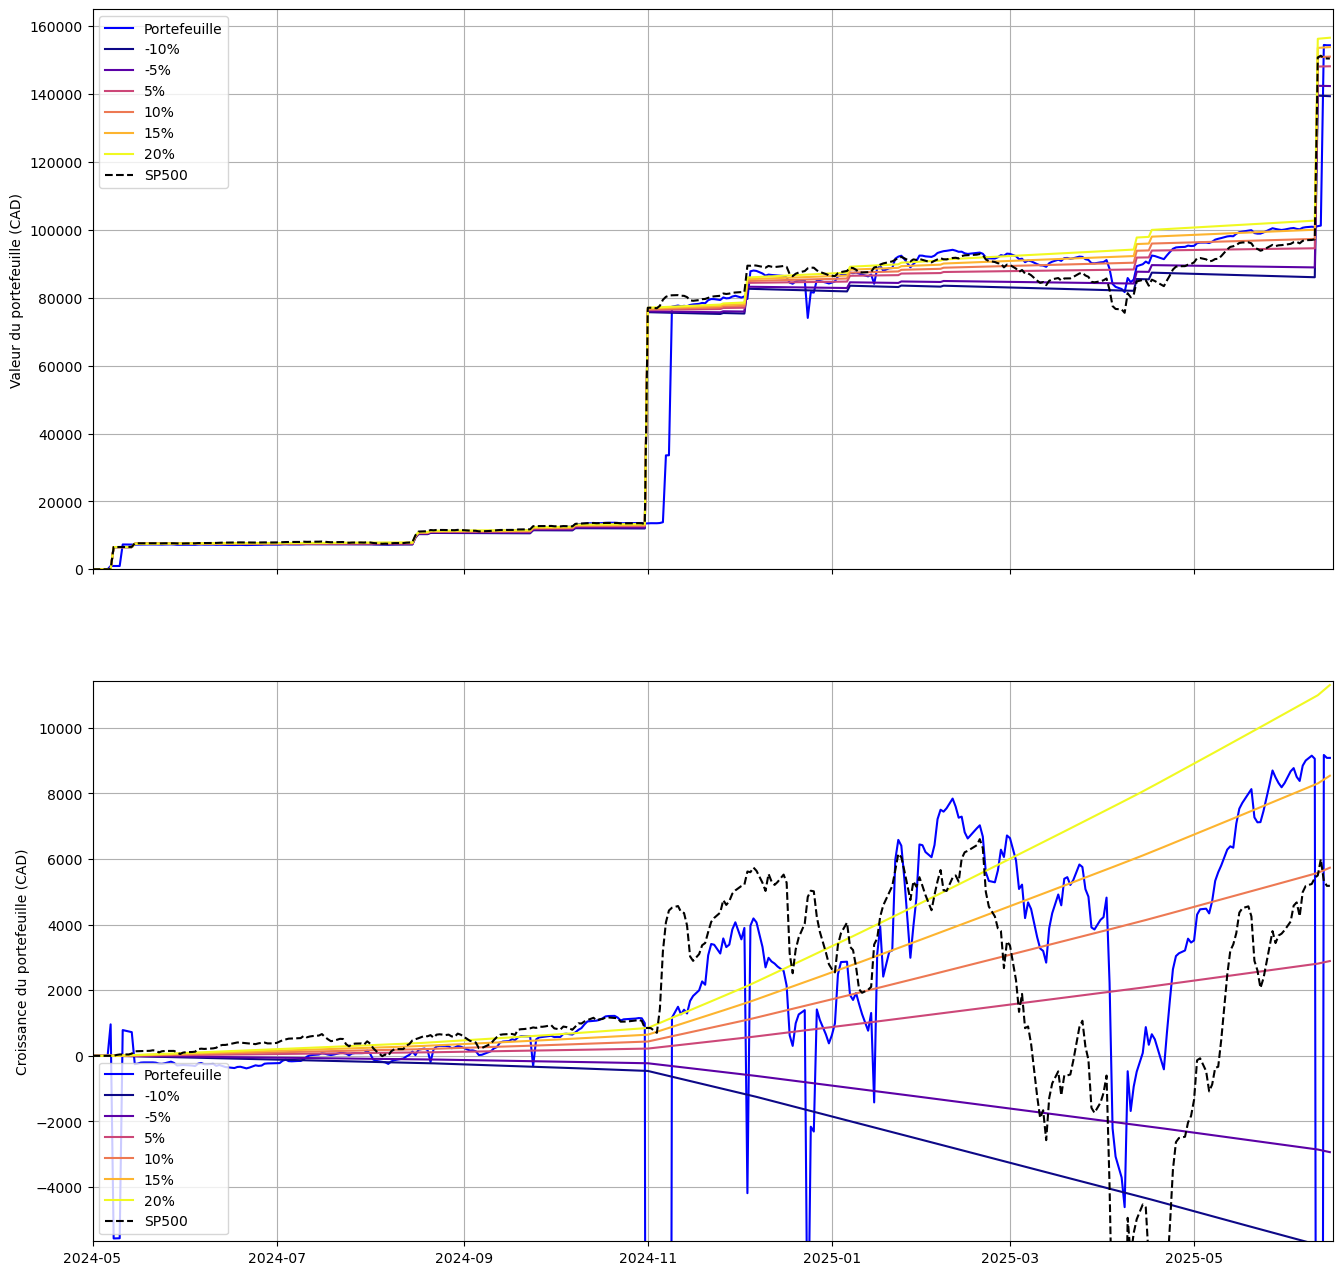

In [7]:
# Plotting the results: portfolio value, synthetic growth scenarios, and effective growth

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), sharex=True)

tbl0['time_plot'] = Time(tbl0['mjd'], format='mjd').datetime

for i in range(2):
    # Reference: 0 for absolute value, or contributions for net growth
    ref = 0 if i == 0 else tbl0['CONTRIBUTIONS']
    # Plot actual portfolio value (or value minus contributions)
    ax[i].plot(tbl0['time_plot'], tbl0['val_total'] - ref, label='Portefeuille', color='blue')

    # Use a heat palette for the synthetic growth scenarios
    norm = mcolors.Normalize(vmin=min(percent_gains), vmax=max(percent_gains))
    cmap = plt.colormaps['plasma']  # Updated to avoid deprecation warning

    for pg in percent_gains:
        color = cmap(norm(pg))
        ax[i].plot(
            tbl0['time_plot'],
            tbl0[f'growth_{pg}_percent'] - ref,
            label=f'{pg}%',
            color=color
        )

    # Plot the synthetic SP500 portfolio
    ax[i].plot(tbl0['time_plot'], tbl0['val_SP500'] - ref, label='SP500', color='black', linestyle='--')

# For scaling the y-axis of the second subplot
maxi = np.max(tbl0[f'growth_{pg}_percent'] - ref)

# Plot effective growth rates
#ax[2].plot(tbl0['time_plot'], tbl0['effective_growth'], label='Croissance effective', color='red')
#ax[2].plot(tbl0['time_plot'], tbl0['effective_growth_sp500'], label='Croissance effective SP500', color='orange')

# Set axis limits and labels
ax[0].set_ylim([0, 165000])
ax[1].set_ylim([-maxi*0.5,  (maxi * 1.01)])
#ax[2].set_ylim([-25, 25])
ax[0].legend()
ax[1].legend(loc = 'lower left')
ax[0].grid()
ax[1].grid()
#ax[2].grid()
#ax[2].set_xlabel('Date')
ax[0].set_ylabel('Valeur du portefeuille (CAD)')
ax[1].set_ylabel('Croissance du portefeuille (CAD)')
#ax[2].set_ylabel('Croissance effective (%)')
ax[0].set_xlim(Time('2024-05-01', format='iso').datetime, Time.now().datetime)
plt.show()

In [8]:
latest_portfolio = []
vv = np.zeros(len(tbl0), dtype=float)
total_last = 0.0
for sym in symbols: 
    last_quantity = tbl0[sym+'_quantity'][-1]
    if last_quantity == 0:
        continue
    last_val = tbl0[sym+'_val'][-1]
    total_last += last_val
    bt.printc(f'{sym:<10} \t {last_quantity} \t {bt.pdollar(last_val):<10}\t {last_val/last_quantity:.2f} CAD')
    if '-U' in sym:
        last_val /= tbl0['CADUSD'][-1]
    last_val = np.round(last_val, 2)
    sym = sym.replace('-U', '').replace('.TO', '')
    latest_portfolio.append((sym, last_quantity, last_val))

    tmp = np.array(tbl0[sym+'_dividend'])
    tmp/=tmp[0]
    tmp*= last_quantity
    vv += tmp

bt.printc(f'Total: {bt.pdollar(total_last)} CAD')
bt.printc('Latest CAD/USD rate: ' + str(1/tbl0['CADUSD'][-1]))



21:09:09.956 |  BKCL-C     	 201 	 3 814,98$ 	 18.98 CAD
21:09:09.958 |  DMEC-C     	 343 	 8 485,82$ 	 24.74 CAD
21:09:09.962 |  DRFC-C     	 846 	 29 863,80$	 35.30 CAD
21:09:09.963 |  EBNK-C     	 1354 	 18 279,00$	 13.50 CAD
21:09:09.963 |  HURA-C     	 135 	 5 292,00$ 	 39.20 CAD
21:09:09.964 |  XUSC.U-C   	 271 	 12 016,14$	 44.34 CAD
21:09:09.965 |  ZEA-C      	 760 	 19 410,40$	 25.54 CAD
21:09:09.966 |  ZGQ-C      	 97 	 6 738,59$ 	 69.47 CAD
21:09:09.966 |  ZID-C      	 134 	 6 687,94$ 	 49.91 CAD
21:09:09.967 |  ZLU-C      	 122 	 6 711,22$ 	 55.01 CAD
21:09:09.967 |  ZLU.U-C    	 308 	 16 943,08$	 55.01 CAD
21:09:09.968 |  ZUQ-C      	 77 	 6 667,43$ 	 86.59 CAD
21:09:09.968 |  ZWE-C      	 333 	 6 806,52$ 	 20.44 CAD
21:09:09.969 |  ZWG-C      	 215 	 6 682,20$ 	 31.08 CAD
21:09:09.970 |  Total: 154 399,12$ CAD
21:09:09.970 |  Latest CAD/USD rate: 1.3619400101439967


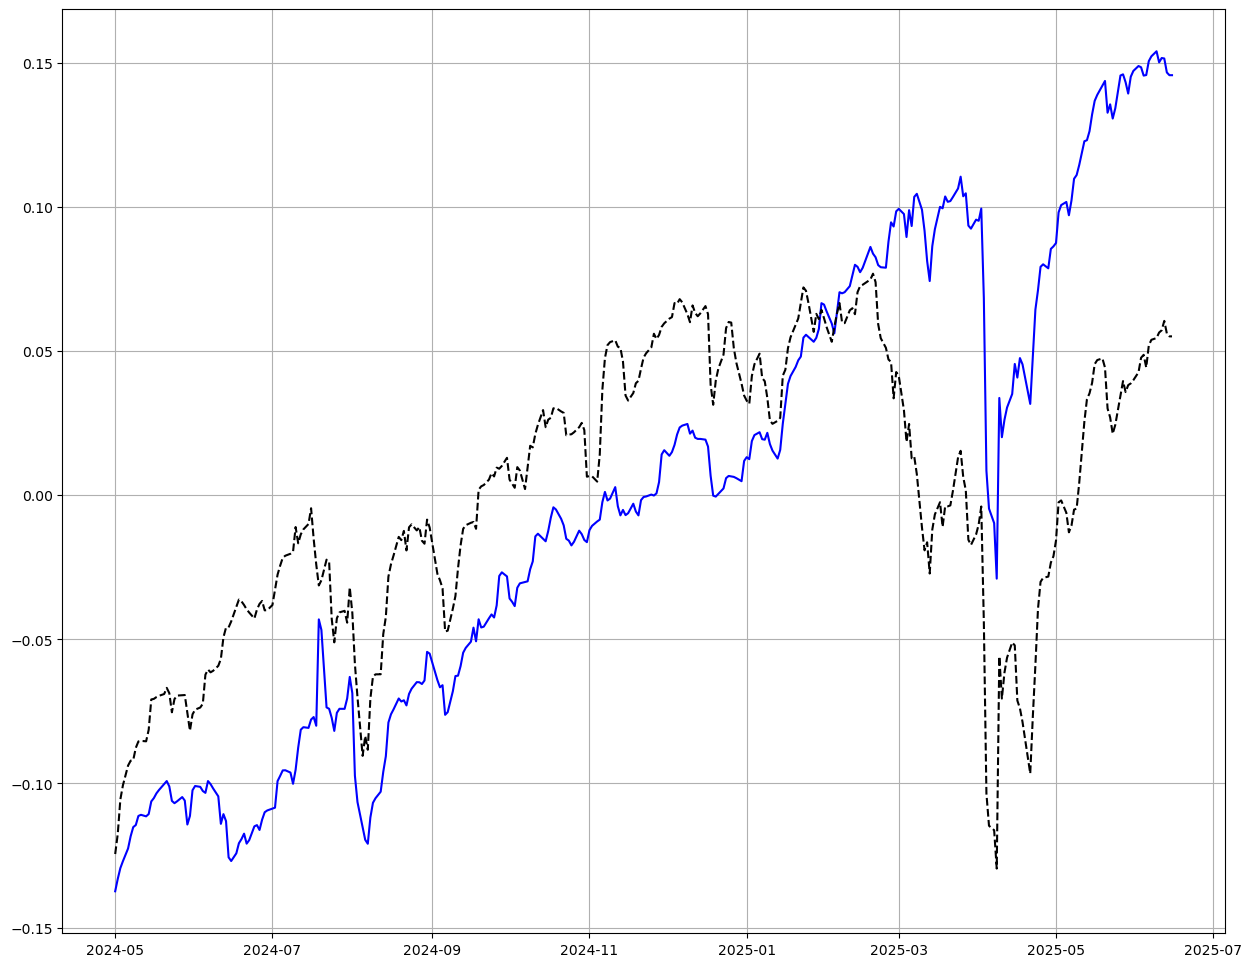

21:09:10.325 |  Effective mean growth: 24.22 %/an (std: 2.22 %/an)
21:09:10.328 |  Effective mean growth SP500: 7.79 %/an (std: 4.20 %/an)


In [9]:

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(tbl0['time_plot'], np.log(vv)-np.mean(np.log(vv)), label='Portefeuille', color='blue')
vv_sp500 = tbl0['SP500'] 
ax.plot(tbl0['time_plot'], np.log(vv_sp500)-np.mean(np.log(vv_sp500)), label='SP500', color='black', linestyle='--')
ax.grid()
plt.show()

fit = np.polyfit(tbl0['mjd']/364.24,np.log(vv), 1)
std = np.std(np.log(vv) - (fit[0] * tbl0['mjd']/364.24 + fit[1]))
bt.printc(f'Effective mean growth: {fit[0]*100.0:.2f} %/an (std: {std*100.0:.2f} %/an)')
std = np.std(np.log(vv_sp500) - (np.polyfit(tbl0['mjd']/364.24,np.log(vv_sp500), 1)[0] * tbl0['mjd']/364.24 + np.polyfit(tbl0['mjd']/364.24,np.log(vv_sp500), 1)[1]))
bt.printc(f'Effective mean growth SP500: {np.polyfit(tbl0['mjd']/364.24,np.log(vv_sp500), 1)[0]*100.0:.2f} %/an (std: {std*100.0:.2f} %/an)')


In [10]:

current_value = tbl0['val_total'][-1] #95450.78

#input keys
keys = 'COTISATION','TRANSFERT REÇU'

keep_injection = [tbl['Type de transaction'][i] in keys for i in range(len(tbl))]

tbl = tbl[keep_injection]
# remove any USD in 'Devise du compte'
tbl = tbl[tbl['Devise du compte'] != 'USD']

tbl["Montant"] = tbl["Montant de l'opération"].astype(float)
tbl['Time_ago'] = Time.now().mjd-Time(tbl['Date de règlement']).mjd

growth_rate = -0.1

def get_current_account(growth_rate):
    return np.sum((1+growth_rate)**(tbl['Time_ago']/365.24)*tbl["Montant"])
def get_val(growth_rate):
    return np.abs(get_current_account(growth_rate)-current_value)

growth_rate = minimize(get_val,0.1).x[0]

total_cost = np.sum(tbl["Montant"])
bt.printc(f'Total cost : {total_cost:.2f}$')

value_sp500 =  np.sum(tbl["Montant de l'opération"]/tbl['SP500'])*sp500['Close'][-1]

bt.printc(f'Value SP500 : {value_sp500:.2f}$')

current_computed = get_current_account(growth_rate)
bt.printc(f'Current : {current_value:.2f}$')
bt.printc(f'Current -computed- : {current_computed:.2f}$')
bt.printc(f'Current growth rate : {100*growth_rate:.2f}%')
bt.printc(f'Latest value of SP500 : {sp500["Close"][-1]}$')
bt.printc(f'Value if investing everything in SP500 : {value_sp500:.2f}$')

21:09:10.366 |  Total cost : 145315.34$
21:09:10.367 |  Value SP500 : 150625.55$
21:09:10.368 |  Current : 154399.12$
21:09:10.368 |  Current -computed- : 154399.12$
21:09:10.369 |  Current growth rate : 15.78%
21:09:10.369 |  Latest value of SP500 : 6009.0400390625$
21:09:10.370 |  Value if investing everything in SP500 : 150625.55$
